In [24]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from transformers import (
    T5ForConditionalGeneration,
    T5TokenizerFast as T5Tokenizer,
    BartTokenizer,
    BartForConditionalGeneration,
    GPT2LMHeadModel,
    GPT2Tokenizer
)

from evaluate import load

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

from models.HeadlineGenerationModel import HeadlineGenerationModel
from models.NewsHeadlineDataModule import NewsHeadlineDataModule
from models.BartHeadlineGenerationModel import BartHeadlineGenerationModel

from evaluation.generate_headline import generate_headline
from evaluation.get_topn_words import get_topn_words
from evaluation.calculate_perplexity import calculate_perplexity
from evaluation.evaluate import calculate_scores_df_tuned, calculate_scores_df

In [2]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')
    PATH = '/content/drive/My Drive/UNI/sem6/NLP/project/articles_bbc.csv'
else:
    PATH = 'data/articles_bbc.csv'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
data = pd.read_csv(PATH, index_col=0)
df = data[['Article', 'Headline']]
print(df.shape)
data.head(10)

(2225, 2)


,Article,Headline,Summary
0,Quarterly profits at US media giant TimeWarner...,Ad sales boost Time Warner profit,TimeWarner said fourth quarter sales rose 2% t...
1,The dollar has hit its highest level against t...,Dollar gains on Greenspan speech,The dollar has hit its highest level against t...
2,The owners of embattled Russian oil giant Yuko...,Yukos unit buyer faces loan claim,Yukos' owner Menatep Group says it will ask Ro...
3,British Airways has blamed high fuel prices fo...,High fuel prices hit BA's profits,"Rod Eddington, BA's chief executive, said the ..."
4,Shares in UK drinks and food firm Allied Domec...,Pernod takeover talk lifts Domecq,Pernod has reduced the debt it took on to fund...
5,Japan's economy teetered on the brink of a tec...,Japan narrowly escapes recession,"On an annual basis, the data suggests annual g..."
6,The US created fewer jobs than expected in Jan...,Jobs growth still slow in the US,The job gains mean that President Bush can cel...
7,"India, which attends the G7 meeting of seven l...",India calls for fair trade rules,At a conference on developing enterprise hoste...
8,Ethiopia produced 14.27 million tonnes of crop...,Ethiopia's crop production up 24%,"In 2003, crop production totalled 11.49 millio..."
9,A US government claim accusing the country's b...,Court rejects $280bn tobacco case,A US government claim accusing the country's b...


In [5]:
train_df, rest_df = train_test_split(df, test_size=0.2)
test_df, val_df = train_test_split(rest_df, test_size=0.5)

train_df.shape, val_df.shape, test_df.shape

((1780, 2), (223, 2), (222, 2))

# T5-small model fine-tuning

In [6]:
tokenizer = T5Tokenizer.from_pretrained('t5-small', model_max_length=512)

In [7]:
article_token_counts, headline_token_counts = [], []

for _, row in train_df.iterrows():
    article_token_count = len(tokenizer.encode(row["Article"]))
    article_token_counts.append(article_token_count)

    headline_token_count = len(tokenizer.encode(row["Headline"]))
    headline_token_counts.append(headline_token_count)

Token indices sequence length is longer than the specified maximum sequence length for this model (618 > 512). Running this sequence through the model will result in indexing errors


Text(0.5, 1.0, 'headline text token counts')

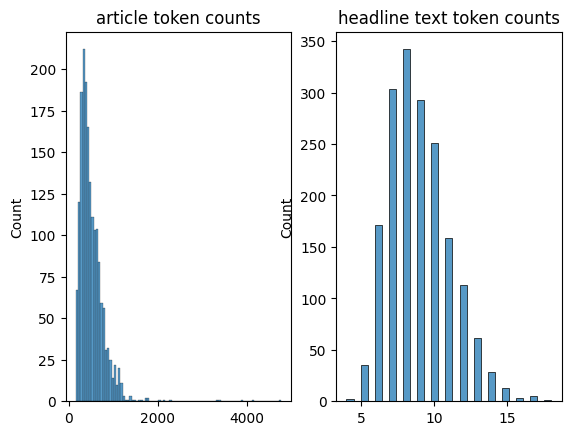

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2)

sns.histplot(article_token_counts, ax=ax1)
ax1.set_title("article token counts")

sns.histplot(headline_token_counts, ax=ax2)
ax2.set_title("headline text token counts")

In [9]:
data_module_t5 = NewsHeadlineDataModule(
    train_df,
    val_df,
    test_df,
    tokenizer,
    batch_size=8)

In [15]:
model_t5 = HeadlineGenerationModel("t5-small")

In [11]:
log_path = "logs/t5-small"
checkpoint_path = "checkpoints/t5-small"


checkpoint_callback = ModelCheckpoint(
    dirpath=checkpoint_path,
    filename="best-checkpoint-t5",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

logger = TensorBoardLogger(log_path, name="news-headline")

trainer = pl.Trainer(
    logger=logger,
    callbacks=checkpoint_callback,
    max_epochs=10,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [18]:
trainer.fit(model_t5, data_module_t5)

# BART fine-tuning

In [12]:
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base", model_max_length=512)

In [13]:
data_module_bart = NewsHeadlineDataModule(train_df, val_df, test_df, tokenizer, batch_size=8)

In [14]:
model_bart = HeadlineGenerationModel("facebook/bart-base")

In [15]:
log_path = 'logs/bart'
checkpoint_path =  'checkpoints/bart'

checkpoint_callback = ModelCheckpoint(
    dirpath=checkpoint_path,
    filename="best-checkpoint-bart",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

logger = TensorBoardLogger(log_path, name="news-headline")

trainer = pl.Trainer(
    logger=logger,
    callbacks=checkpoint_callback,
    max_epochs=10,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [16]:
trainer.fit(model_bart, data_module_bart)

# Testing

In [8]:
trained_t5 = HeadlineGenerationModel.load_from_checkpoint("checkpoints/t5-small/best-checkpoint-t5.ckpt").model.to(device)
pretrained_t5 = T5ForConditionalGeneration.from_pretrained("t5-small", return_dict=True).to(device)
tokenizer_t5 = T5Tokenizer.from_pretrained('t5-small', model_max_length=512)
trained_bart = BartHeadlineGenerationModel.load_from_checkpoint("checkpoints/bart/best-checkpoint-bart.ckpt").model.to(device)
pretrained_bart = BartForConditionalGeneration.from_pretrained("facebook/bart-base", return_dict=True).to(device)
tokenizer_bart = BartTokenizer.from_pretrained("facebook/bart-base", model_max_length=512)

In [44]:
sample_row = data.iloc[1]
text = sample_row["Article"]
hd = sample_row["Headline"]
summary = sample_row['Summary']

print(len(text.split(" ")))
print(f"True headline: {hd}")

381
True headline: Dollar gains on Greenspan speech


In [45]:
print(f"Tuned T5: {generate_headline(text, tokenizer_t5, trained_t5, max_new_tokens=20)}")
print(f"Pretrained T5: {generate_headline(text, tokenizer_t5, pretrained_t5, prompt='summarize: ')}\n")

print(f"Tuned Bart: {generate_headline(text, tokenizer_bart, trained_bart, max_new_tokens=20)}")
print(f"Pretrained Bart: {generate_headline(text, tokenizer_bart, pretrained_bart, prompt='')}")

Tuned T5: US trade deficit hits greenback
Pretrained T5: in late trading in new york, the dollar reached $1.2871 against the euro. the

Tuned Bart: US trade deficit 'to stabilise'
Pretrained Bart: The dollar has hit its highest level against the euro in almost three months after the Federal Reserve


In [9]:
testing_df = data.sample(100).reset_index()

In [10]:
scores_df = calculate_scores_df(testing_df, tokenizer_t5, pretrained_t5, trained_t5, tokenizer_bart, pretrained_bart, trained_bart, include_summary=True)

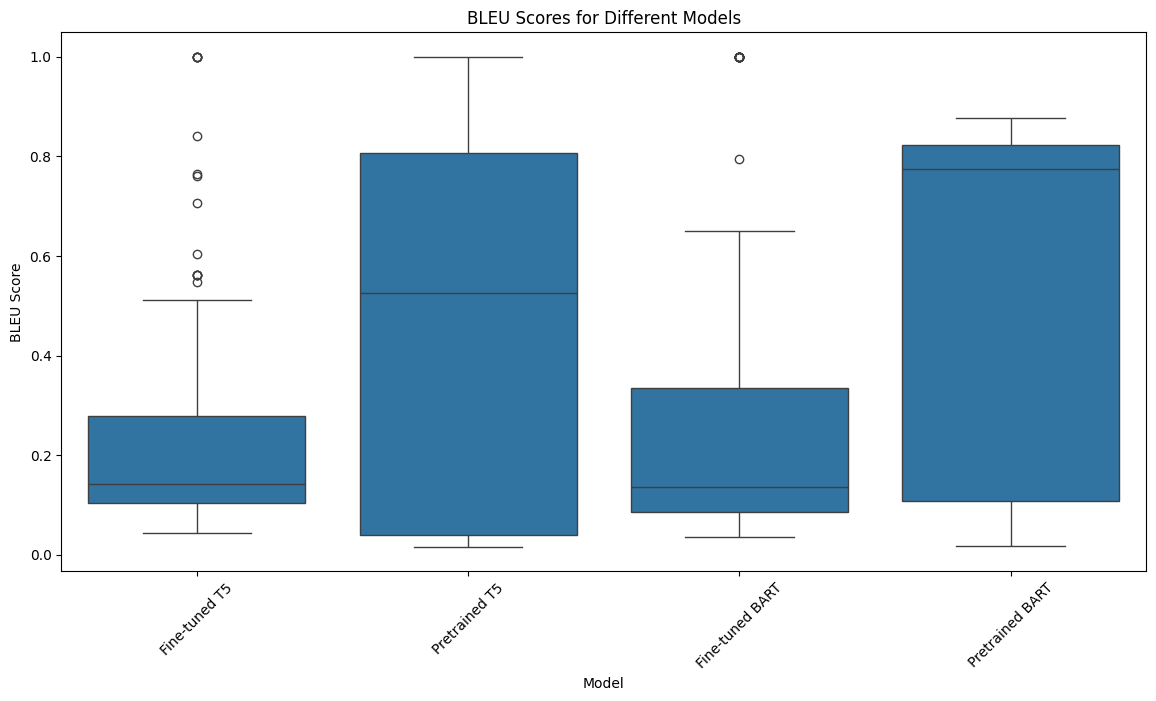

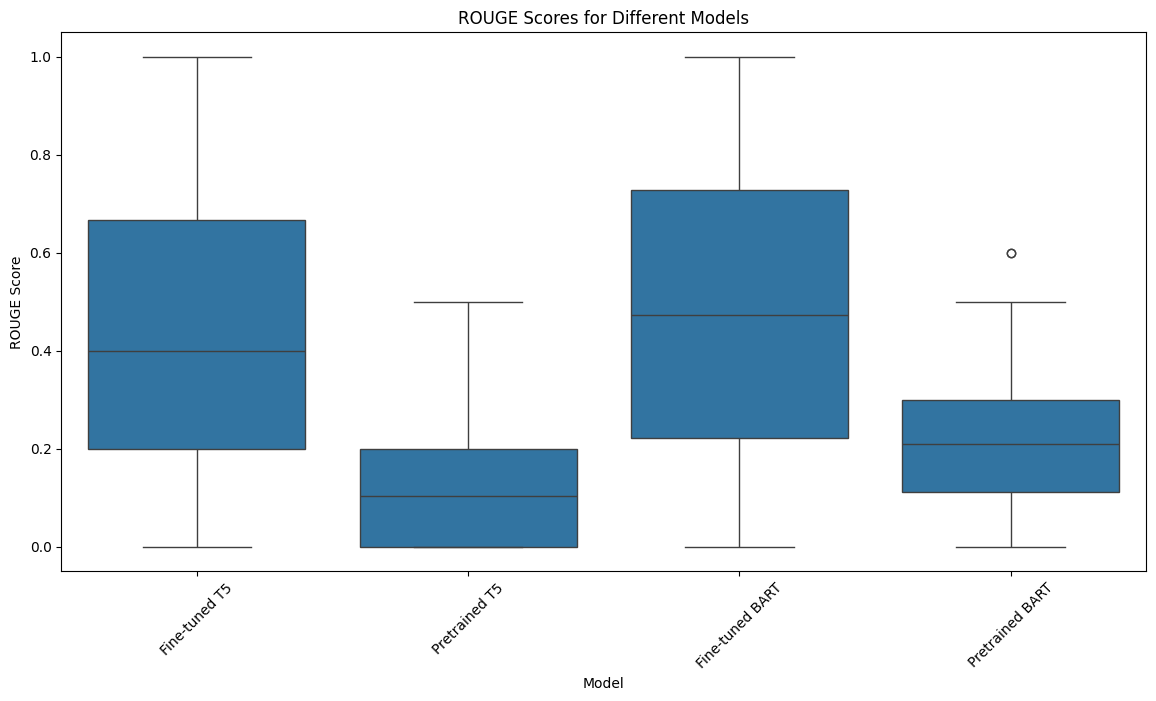

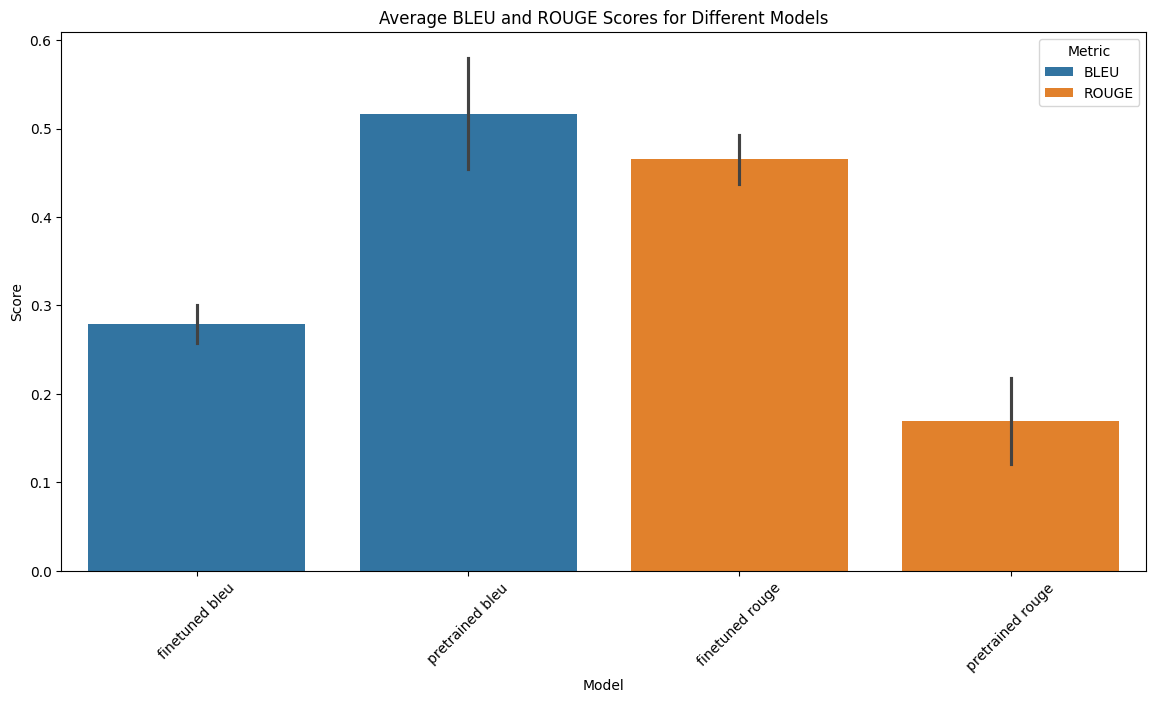

In [11]:
melted_bleu = scores_df.melt(id_vars=['index'], value_vars=['bleu_finetuned_t5', 'bleu_pretrained_t5', 'bleu_finetuned_bart', 'bleu_pretrained_bart'],
                             var_name='Model', value_name='BLEU Score')
melted_rouge = scores_df.melt(id_vars=['index'], value_vars=['rouge_finetuned_t5', 'rouge_pretrained_t5', 'rouge_finetuned_bart', 'rouge_pretrained_bart'],
                              var_name='Model', value_name='ROUGE Score')

model_mapping = {
    'bleu_finetuned_t5': 'Fine-tuned T5',
    'bleu_pretrained_t5': 'Pretrained T5',
    'bleu_finetuned_bart': 'Fine-tuned BART',
    'bleu_pretrained_bart': 'Pretrained BART',
    'rouge_finetuned_t5': 'Fine-tuned T5',
    'rouge_pretrained_t5': 'Pretrained T5',
    'rouge_finetuned_bart': 'Fine-tuned BART',
    'rouge_pretrained_bart': 'Pretrained BART'
}
melted_bleu['Model'] = melted_bleu['Model'].map(model_mapping)
melted_rouge['Model'] = melted_rouge['Model'].map(model_mapping)

plt.figure(figsize=(14, 7))
sns.boxplot(data=melted_bleu, x='Model', y='BLEU Score')
plt.title('BLEU Scores for Different Models')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(14, 7))
sns.boxplot(data=melted_rouge, x='Model', y='ROUGE Score')
plt.title('ROUGE Scores for Different Models')
plt.xticks(rotation=45)
plt.show()

avg_scores = scores_df[['bleu_finetuned_t5', 'bleu_pretrained_t5',
                        'bleu_finetuned_bart', 'bleu_pretrained_bart',
                        'rouge_finetuned_t5', 'rouge_pretrained_t5',
                        'rouge_finetuned_bart', 'rouge_pretrained_bart']].mean()

avg_scores = avg_scores.reset_index()
avg_scores.columns = ['Metric', 'Score']
avg_scores['Model'] = avg_scores['Metric'].apply(lambda x: x.split('_')[1] + ' ' + x.split('_')[0])
avg_scores['Metric'] = avg_scores['Metric'].apply(lambda x: 'BLEU' if 'bleu' in x else 'ROUGE')

plt.figure(figsize=(14, 7))
sns.barplot(data=avg_scores, x='Model', y='Score', hue='Metric')
plt.title('Average BLEU and ROUGE Scores for Different Models')
plt.xticks(rotation=45)
plt.show()


# Unseen dataset testing

In [10]:
unseen_data = pd.read_csv('data/archive/Articles.csv', encoding='cp1252')
unseen_data = unseen_data[['Article', 'Heading']].sample(100).reset_index().drop(columns=['index']).rename(columns={"Heading": "Headline"})
unseen_data

,Article,Headline
0,ISLAMABAD: Pakistan's car market has been domi...,pakistans japanese dominated car market poised...
1,Hong Kong: Asian markets extended their rally ...,asia stocks mostly higher ahead of ecb meeting
2,strong>Tokyo: Tokyo stocks opened lower Monday...,Tokyo stocks open lower after BoJ under
3,KARACHI: Wholesale market rates for sugar drop...,sugar prices drop to rs 49.80 in sind
4,Tokyo: The dollar held steady on Wednesday aft...,Dollar steady ahead of Fed rate hike decisi
...,...,...
95,London: Oil prices rebounded Friday on bargain...,oil rebounds after volatile
96,strong>LONDON: Pakistan captain Misbah-ul-Haq ...,Promised army guys 10 push ups century Misb
97,Singapore: Oil prices fell in Asia Tuesday as ...,oil prices down in asian trad
98,ISLAMABAD: Anam Amin became the only Pakistani...,Only Anam from Pakistan included in ICC


In [ ]:
results_unseen = calculate_scores_df(unseen_data, tokenizer_t5, pretrained_t5, trained_t5, tokenizer_bart, pretrained_bart, trained_bart, include_summary=False, verbose=True)

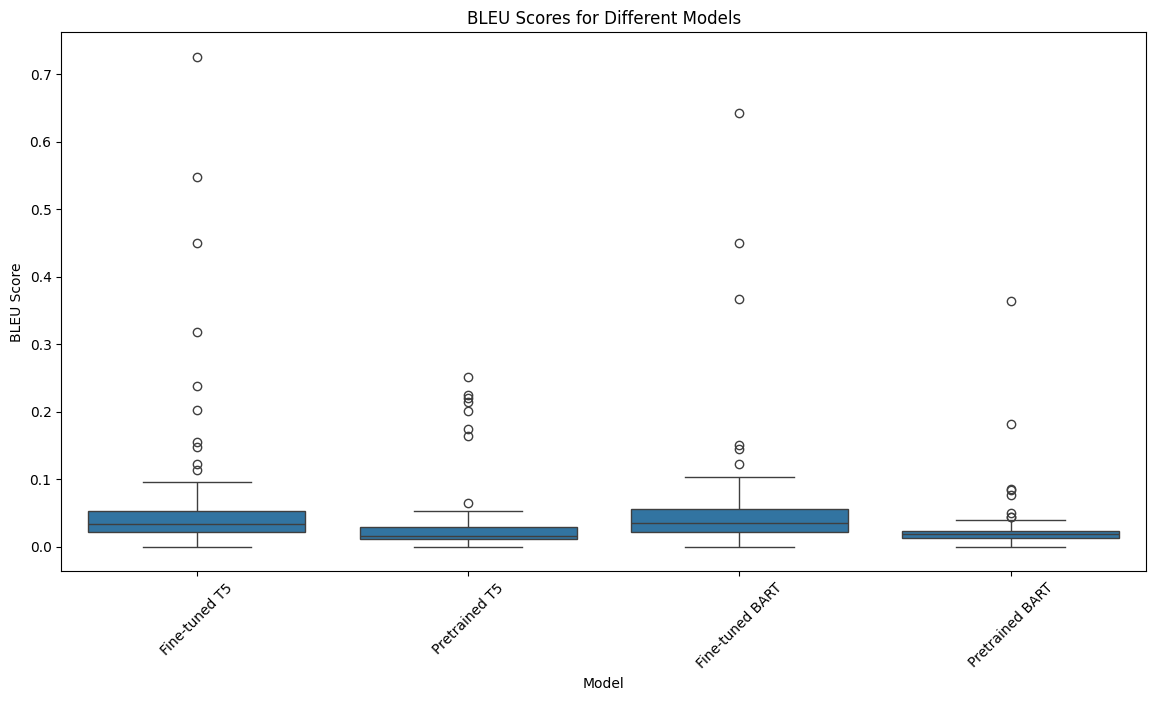

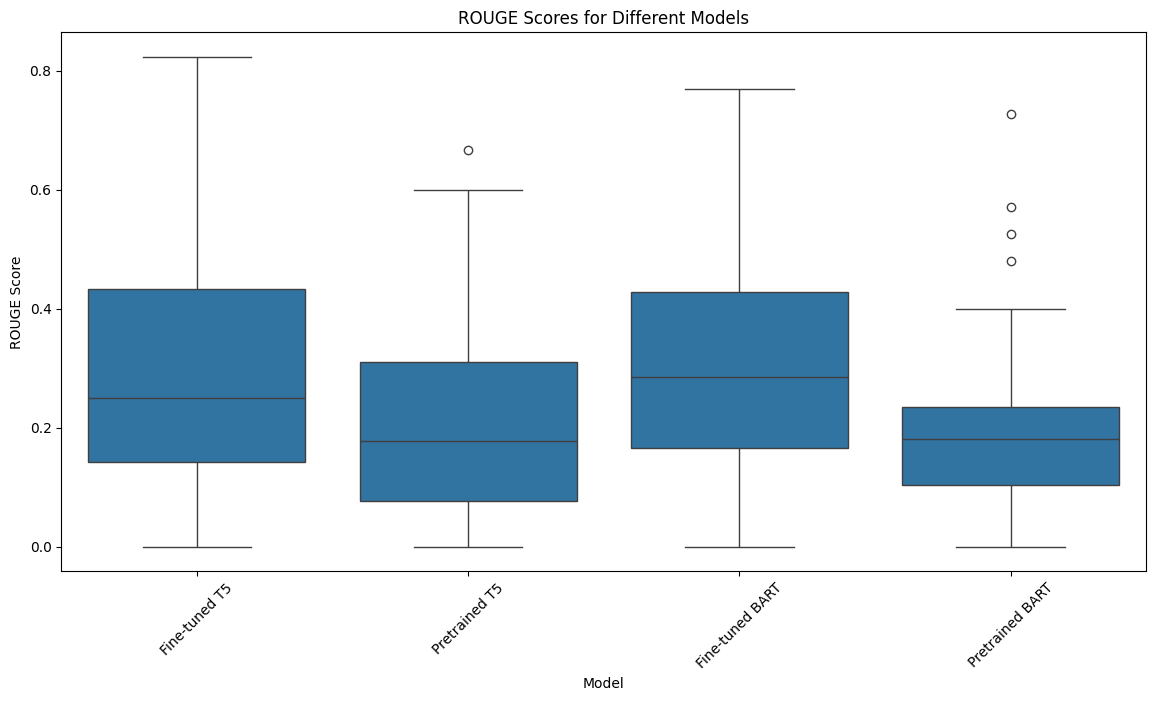

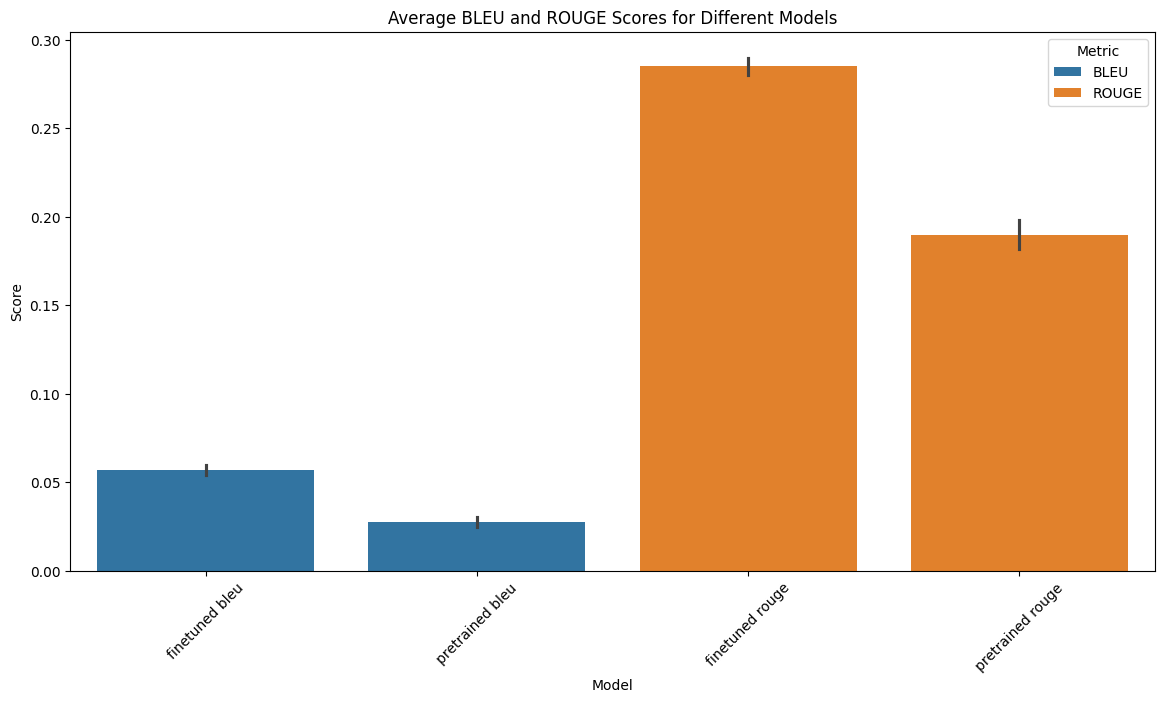

In [15]:
melted_bleu = results_unseen.melt(id_vars=['index'], value_vars=['bleu_finetuned_t5', 'bleu_pretrained_t5', 'bleu_finetuned_bart', 'bleu_pretrained_bart'],
                              var_name='Model', value_name='BLEU Score')
melted_rouge = results_unseen.melt(id_vars=['index'], value_vars=['rouge_finetuned_t5', 'rouge_pretrained_t5', 'rouge_finetuned_bart', 'rouge_pretrained_bart'],
                               var_name='Model', value_name='ROUGE Score')

model_mapping = {
    'bleu_finetuned_t5': 'Fine-tuned T5',
    'bleu_pretrained_t5': 'Pretrained T5',
    'bleu_finetuned_bart': 'Fine-tuned BART',
    'bleu_pretrained_bart': 'Pretrained BART',
    'rouge_finetuned_t5': 'Fine-tuned T5',
    'rouge_pretrained_t5': 'Pretrained T5',
    'rouge_finetuned_bart': 'Fine-tuned BART',
    'rouge_pretrained_bart': 'Pretrained BART'
}
melted_bleu['Model'] = melted_bleu['Model'].map(model_mapping)
melted_rouge['Model'] = melted_rouge['Model'].map(model_mapping)


plt.figure(figsize=(14, 7))
sns.boxplot(data=melted_bleu, x='Model', y='BLEU Score')
plt.title('BLEU Scores for Different Models')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(14, 7))
sns.boxplot(data=melted_rouge, x='Model', y='ROUGE Score')
plt.title('ROUGE Scores for Different Models')
plt.xticks(rotation=45)
plt.show()

avg_scores = results_unseen[['bleu_finetuned_t5', 'bleu_pretrained_t5',
                             'bleu_finetuned_bart', 'bleu_pretrained_bart',
                             'rouge_finetuned_t5', 'rouge_pretrained_t5',
                             'rouge_finetuned_bart', 'rouge_pretrained_bart']].mean()

avg_scores = avg_scores.reset_index()
avg_scores.columns = ['Metric', 'Score']
avg_scores['Model'] = avg_scores['Metric'].apply(lambda x: x.split('_')[1] + ' ' + x.split('_')[0])
avg_scores['Metric'] = avg_scores['Metric'].apply(lambda x: 'BLEU' if 'bleu' in x else 'ROUGE')

plt.figure(figsize=(14, 7))
sns.barplot(data=avg_scores, x='Model', y='Score', hue='Metric')
plt.title('Average BLEU and ROUGE Scores for Different Models')
plt.xticks(rotation=45)
plt.show()

# Perplexity

In [25]:
model = GPT2LMHeadModel.from_pretrained("gpt2")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
perplexity = load("perplexity", module_type='metric')

# Grammatical correctness

In [29]:
import language_tool_python
tool = language_tool_python.LanguageTool('en-US')

In [30]:
testing_df

,index,Article,Headline,Summary
0,1929,Some of the most vivid descriptions of the dev...,Web logs aid disaster recovery,Mr Gupta says the power of Morquendi's text me...
1,574,Oscar-winning director Hayao Miyazaki's latest...,Animation charms Japan box office,It has registered the highest opening weekend ...
2,1228,Ex-chat show host Robert Kilroy-Silk is to con...,Kilroy names election seat target,"UKIP's leader, Roger Knapman, has said he is g..."
3,186,A US bank has said it will donate more than $8...,Bank payout to Pinochet victims,A US bank has said it will donate more than $8...
4,569,The film adaptation of Lemony Snicket novels h...,Snicket tops US box office chart,A Series of Unfortunate Events also stars Scot...
...,...,...,...,...
95,1966,Literally putting a face on technology could b...,Putting a face to 'Big Brother',You might even be able to tell your home surve...
96,1827,"Nicholas Negroponte, chairman and founder of M...",Digital guru floats sub-$100 PC,"He said one laptop per child could be "" very i..."
97,2062,The internet could soon have two new domain na...,Go-ahead for new internet names,The internet could soon have two new domain na...
98,1575,Rangers manager Alex McLeish accepts he is goi...,McLeish ready for criticism,McLeish admitted his team's defending was amat...


In [35]:
grammatical_scores = []
for _, row in testing_df.iterrows():
    print(f"Processing row {_}", end='\r')
    hd = row['Headline']
    hd1 = generate_headline(row['Article'], tokenizer_t5, trained_t5, max_new_tokens=20)
    hd2 = generate_headline(row['Article'], tokenizer_t5, pretrained_t5, max_new_tokens=20)
    hd3 = generate_headline(row['Article'], tokenizer_bart, trained_bart, max_new_tokens=20)
    hd4 = generate_headline(row['Article'], tokenizer_bart, pretrained_bart, max_new_tokens=20)
    grammatical_scores.append((row['Headline'], tool.check(hd), tool.check(hd1), tool.check(hd2), tool.check(hd3), tool.check(hd4)))

In [36]:
print(f"Average number of errors in true headlines: {sum([len(x[1]) for x in grammatical_scores]) / len(grammatical_scores)}")
print(f"Average number of errors in fine-tuned T5 headlines: {sum([len(x[2]) for x in grammatical_scores]) / len(grammatical_scores)}")
print(f"Average number of errors in pretrained T5 headlines: {sum([len(x[3]) for x in grammatical_scores]) / len(grammatical_scores)}")
print(f"Average number of errors in fine-tuned BART headlines: {sum([len(x[4]) for x in grammatical_scores]) / len(grammatical_scores)}")
print(f"Average number of errors in pretrained BART headlines: {sum([len(x[5]) for x in grammatical_scores]) / len(grammatical_scores)}")


Average number of errors in true headlines: 0.29
Average number of errors in fine-tuned T5 headlines: 0.37
Average number of errors in pretrained T5 headlines: 1.31
Average number of errors in fine-tuned BART headlines: 0.32
Average number of errors in pretrained BART headlines: 0.46


# Fine-tuned models comparison 

In [18]:
# take example and generate headlines with force words
example = data.iloc[15]
article = example['Article']
headline = example['Headline']

force_words = get_topn_words(article, 2)
print(f"True headline: {headline}")
print(f"Force words: {force_words}")

True headline: China keeps tight rein on credit
Force words: ['year', 'china']


In [19]:
print(f"Tuned T5: {generate_headline(article, tokenizer_t5, trained_t5, max_new_tokens=20, force_words=force_words)}")
print(f"Tuned Bart: {generate_headline(article, tokenizer_bart, trained_bart, max_new_tokens=20, force_words=force_words)}")

print(f"Tuned T5: {generate_headline(article, tokenizer_t5, trained_t5, max_new_tokens=20)}")
print(f"Tuned Bart: {generate_headline(article, tokenizer_bart, trained_bart, max_new_tokens=20)}")

Tuned T5: China's credit clampdown continues. China's growth at a breakneck year china
Tuned Bart: China's credit controls 'won't stop' growth'China's economy growingyearchina
Tuned T5: China clamps down on credit
Tuned Bart: China clampdown on credit
